## Work Notebook for Requirements Engineering Journal Article

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from patsy import dmatrices
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.stats.diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

import research_utils.utils as utils
from research_utils.database.database import Database
from research_utils.analytics.beta_regression import Beta
from research_utils.analytics.lda import TopicModel

In [2]:
database = Database()

In [3]:
data = pd.read_sql(utils.INPUT_QUERY, database.connection)

In [4]:
tm = TopicModel(25, load=True)

In [5]:
df = tm.load_topic_model_results()

In [6]:
df.head()

,issue_time,issue_id,title,body,organization,package,issue_number,all_content,topics
0,2018-05-03 11:33:46,319883485,"Help command line arguments (-h, --help) are i...",The help arguments implicitly defined by the a...,actor-framework,actor-framework,688,"Help command line arguments (-h, --help) are i...","[0.009083141572773457, 0.009083141572773457, 0..."
1,2015-02-24 20:11:09,58796753,Remove match expr,The main objective of this change is to make C...,actor-framework,actor-framework,242,Remove match expr The main objective of this c...,"[0.006975634954869747, 0.006975634954869747, 0..."
2,2014-12-18 16:09:28,52381894,Enable actor publishing at random high-level port,"With this patch, using 0 as port parameter to ...",actor-framework,actor-framework,218,Enable actor publishing at random high-level p...,"[0.008186651393771172, 0.008186651393771172, 0..."
3,2018-01-08 17:03:43,286813990,The udp basp autoconnection test has a leak,"According to asan, there is a leak in the unit...",actor-framework,actor-framework,647,The udp basp autoconnection test has a leak Ac...,"[0.010533114895224571, 0.3219645917415619, 0.0..."
4,2014-12-17 11:32:12,52229707,Topic/pullrequest,More tests for the jenkins PR builder.\n,actor-framework,actor-framework,216,Topic/pullrequest More tests for the jenkins P...,"[0.013114626519382, 0.013114626519382, 0.01311..."


In [7]:
for i in range(tm.num_topics):
    df['topic_{}'.format(i)] = [x[i] if x else np.nan for x in df['topics']]
    df['topic_{}_2'.format(i)] = df['topic_{}'.format(i)]**2

In [8]:
all_topics = []
reg_topics = []
for i in range(tm.num_topics-1):    
    all_topics.append('topic_{}'.format(i))
    all_topics.append('topic_{}_2'.format(i))
    for j in range(tm.num_topics-1):
        reg_topics.append("topic_{}*topic_{}".format(i, j))
        reg_topics.append("topic_{}_2".format(i, j))

In [9]:
mean_topics = df.groupby(['organization', 'package']).mean()[all_topics]

In [10]:
all_data = mean_topics.merge(data, on=['package', 'organization'])

In [11]:
all_data['crowd_pct_sq'] = np.sqrt(all_data['crowd_pct'])
all_data['crowd_pct_2'] = all_data['crowd_pct']**2
all_data['issues_over_time'] = (all_data['total_issues'] / all_data['project_age'])*7
all_data['avg_clusteringXcrowd_pct'] = all_data['avg_clustering'] * all_data['crowd_pct']
all_data['avg_min_pathXcrowd_pct'] = all_data['avg_min_path'] * all_data['crowd_pct']
all_data['gini_coefficientXcrowd_pct'] = all_data['gini_coefficient'] * all_data['crowd_pct']

In [12]:
base_columns = ['crowd_pct', 'crowd_pct_2',
                'avg_clustering', 'avg_min_path', 'gini_coefficient',
                'avg_clusteringXcrowd_pct', 'avg_min_pathXcrowd_pct', 'gini_coefficientXcrowd_pct',
                'total_contributors', 'project_age']
base_features = ' + '.join(base_columns)

### Regression on Average Comments

Text(0, 0.5, 'Count')

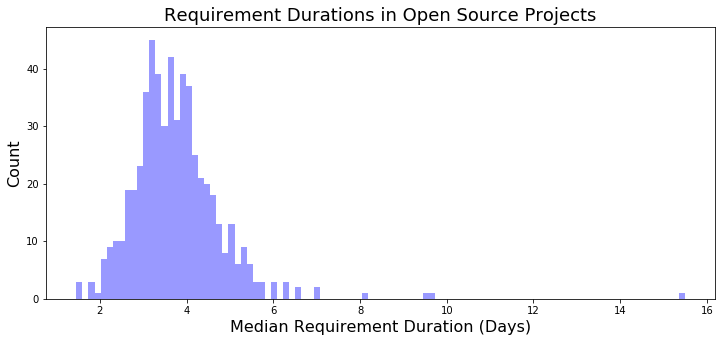

In [13]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['avg_comments'], kde=False, color='blue', bins=100)
plt.title('Requirement Durations in Open Source Projects', fontsize=18)
plt.xlabel('Median Requirement Duration (Days)', fontsize=16)
plt.ylabel('Count', fontsize=16)

In [14]:
all_data['avg_comments'].describe()

count    562.000000
mean       3.766143
std        1.079171
min        1.457227
25%        3.148360
50%        3.629720
75%        4.223124
max       15.493750
Name: avg_comments, dtype: float64

In [15]:
y, X = dmatrices('avg_comments ~ ' + base_features,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           avg_comments   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     21.78
Date:                Mon, 09 Dec 2019   Prob (F-statistic):           2.32e-34
Time:                        23:33:29   Log-Likelihood:                -746.16
No. Observations:                 562   AIC:                             1514.
Df Residuals:                     551   BIC:                             1562.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [16]:
y, X = dmatrices('avg_comments ~ ' + base_features + ' + ' + ' + '.join(reg_topics),
                 data=all_data, return_type='dataframe')
features = utils.select_features(X, y, .10)
y, X = dmatrices('avg_comments ~ ' + features,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           avg_comments   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     8.058
Date:                Mon, 09 Dec 2019   Prob (F-statistic):           6.46e-43
Time:                        23:33:47   Log-Likelihood:                -655.13
No. Observations:                 562   AIC:                             1428.
Df Residuals:                     503   BIC:                             1684.
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

(-2.0, 2.0)

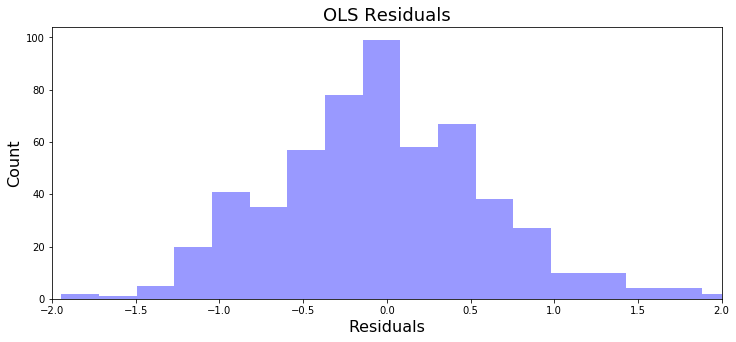

In [17]:
plt.figure(figsize=(12, 5))
sns.distplot(res.resid, kde=False, color='blue', bins=50)
plt.title('OLS Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([-2.0, 2.0])

(-2.0, 2.0)

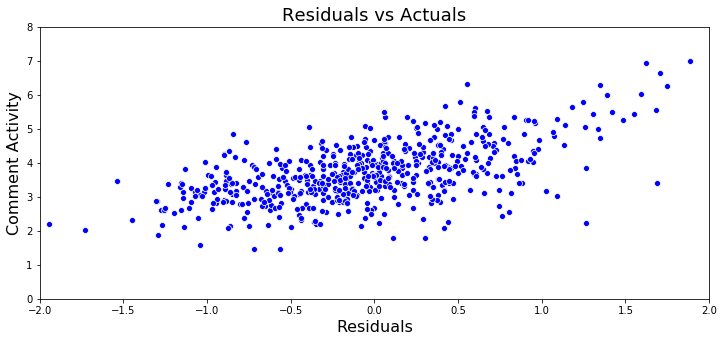

In [18]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=res.resid, y=all_data['avg_comments'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Comment Activity', fontsize=16)
plt.ylim([0, 8])
plt.xlim([-2.0, 2.0])

In [19]:
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(res.summary())

2019-12-09 23:33:48,766 [2584] WARNING  py.warnings: /home/matt/venv/phd/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  """Entry point for launching an IPython kernel.



0.5589808299985086
                 Generalized Linear Model Regression Results                  
Dep. Variable:           avg_comments   No. Observations:                  562
Model:                            GLM   Df Residuals:                      503
Model Family:                   Gamma   Df Model:                           58
Link Function:                    log   Scale:                        0.035295
Method:                          IRLS   Log-Likelihood:                -541.89
Date:                Mon, 09 Dec 2019   Deviance:                       16.744
Time:                        23:33:48   Pearson chi2:                     17.8
No. Iterations:                    15                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Inter

In [20]:
all_data['comment_prediction'] = res.predict(X)

(0, 1.5)

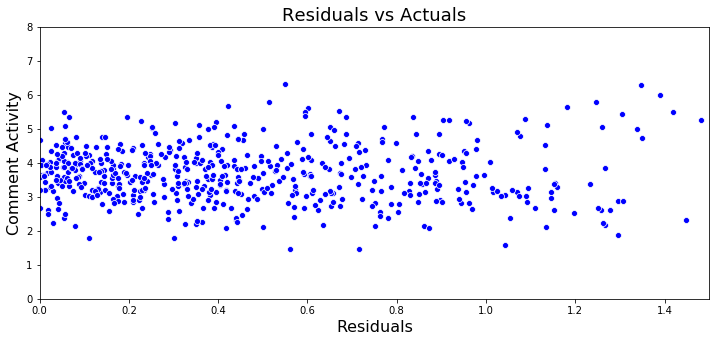

In [21]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=abs(yhat - all_data['avg_comments']), y=all_data['avg_comments'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Comment Activity', fontsize=16)
plt.ylim([0, 8])
plt.xlim([0, 1.5])

In [22]:
marginal_effects = {'crowd_pct': [], 'effect': []}
for i in range(100):
    effects_data = X.copy(deep=True)
    crowd_pct = i/100
    effects_data['crowd_pct_2'] = crowd_pct**2
    effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*all_data['avg_clustering']
    effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*all_data['avg_min_path']
    effects_data['predictions'] = res.predict(effects_data)
    effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
    effects_data['crowd_pct_param'] = (effects_data['avg_clustering'] * res.params['avg_clusteringXcrowd_pct']
                                       + effects_data['avg_min_path'] * res.params['avg_min_pathXcrowd_pct'])
    effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] *crowd_pct
                                                                  + effects_data['crowd_pct_param'])
    avg_effect = effects_data['total_effect'].mean()
    marginal_effects['crowd_pct'].append(crowd_pct)
    marginal_effects['effect'].append(avg_effect)
marginal_effects = pd.DataFrame(marginal_effects)

Text(0.5, 0, 'Crowd Source Percentage')

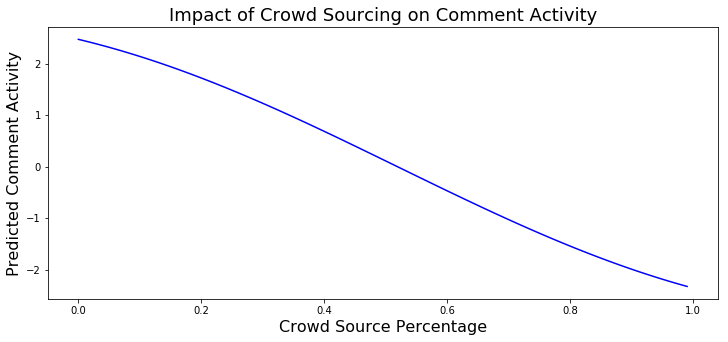

In [23]:
plt.figure(figsize=(12, 5))
sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], color='blue')
plt.title('Impact of Crowd Sourcing on Comment Activity', fontsize=18)
plt.ylabel('Predicted Comment Activity', fontsize=16)
plt.xlabel('Crowd Source Percentage', fontsize=16)

In [24]:
all_data[['avg_clustering', 'avg_min_path']].describe()

,avg_clustering,avg_min_path
count,562.000000,562.000000
mean,0.601003,2.187393
std,0.140855,0.232263
min,0.000000,1.400000
25%,0.522477,2.012390
50%,0.627541,2.145767
75%,0.704530,2.331743
max,0.878524,3.054147


Text(0.5, 0, 'Marginal Effect')

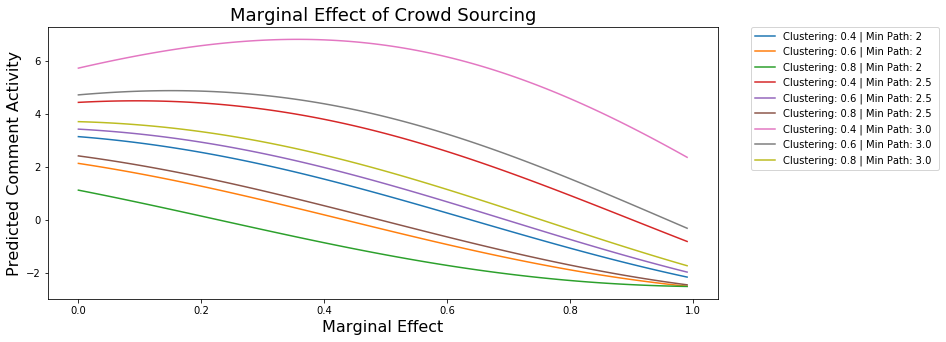

In [25]:
combos = [(0.4, 2),
          (0.6, 2),
          (0.8, 2),
          (0.4, 2.5),
          (0.6, 2.5),
          (0.8, 2.5),
          (0.4, 3.0),
          (0.6, 3.0),
          (0.8, 3.0)]

plt.figure(figsize=(12, 5))

for combo in combos:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    avg_clustering, avg_min_path = combo
    label = 'Clustering: {} | Min Path: {} '.format(avg_clustering, avg_min_path)
    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['crowd_pct_2'] = crowd_pct**2
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct*avg_clustering
        effects_data['avg_min_pathXcrowd_pct'] = crowd_pct*avg_min_path
        effects_data['predictions'] = res.predict(effects_data)
        effects_data['crowd_pct_2_effect'] = effects_data['predictions'] * res.params['crowd_pct_2']
        effects_data['crowd_pct_param'] = (avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct'])
        effects_data['total_effect'] = effects_data['predictions'] * (2 * res.params['crowd_pct_2'] * crowd_pct
                                                                      + effects_data['crowd_pct_param'])
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Marginal Effect of Crowd Sourcing', fontsize=18)
plt.ylabel('Predicted Comment Activity', fontsize=16)
plt.xlabel('Marginal Effect', fontsize=16)

### Regression on Median Requirement Duration

(0, 200)

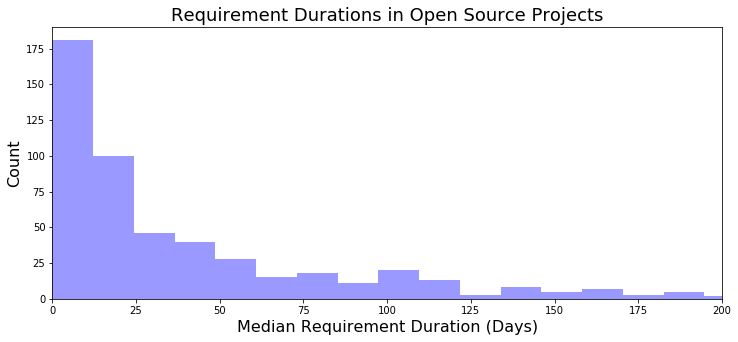

In [26]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['duration_median'], kde=False, color='blue', bins=100)
plt.title('Requirement Durations in Open Source Projects', fontsize=18)
plt.xlabel('Median Requirement Duration (Days)', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([0,200])

In [27]:
all_data['duration_median'].describe()

count     562.000000
mean       74.580071
std       132.147806
min         0.000000
25%         9.000000
50%        24.500000
75%        82.750000
max      1217.000000
Name: duration_median, dtype: float64

In [28]:
y, X = dmatrices('duration_median ~ ' + base_features + ' + total_issues ',
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        duration_median   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     13.16
Date:                Mon, 09 Dec 2019   Prob (F-statistic):           2.15e-22
Time:                        23:34:07   Log-Likelihood:                -3476.0
No. Observations:                 562   AIC:                             6976.
Df Residuals:                     550   BIC:                             7028.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [29]:
y, X = dmatrices('duration_median ~ ' + base_features + ' + total_issues + ' + ' + '.join(reg_topics),
                 data=all_data, return_type='dataframe')
features = utils.select_features(X, y, .12)
y, X = dmatrices('duration_median ~ crowd_pct + avg_clusteringXcrowd_pct - avg_clustering ' + features ,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        duration_median   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     5.351
Date:                Mon, 09 Dec 2019   Prob (F-statistic):           4.01e-39
Time:                        23:34:28   Log-Likelihood:                -3283.9
No. Observations:                 562   AIC:                             6816.
Df Residuals:                     438   BIC:                             7353.
Df Model:                         123                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

(-250, 250)

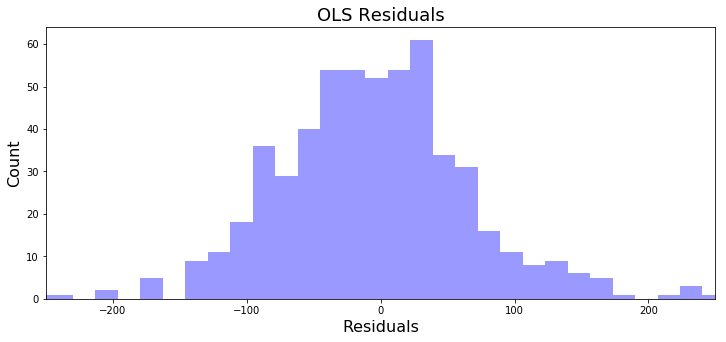

In [30]:
plt.figure(figsize=(12, 5))
sns.distplot(res.resid, kde=False, color='blue', bins=50)
plt.title('OLS Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([-250, 250])

(-200, 200)

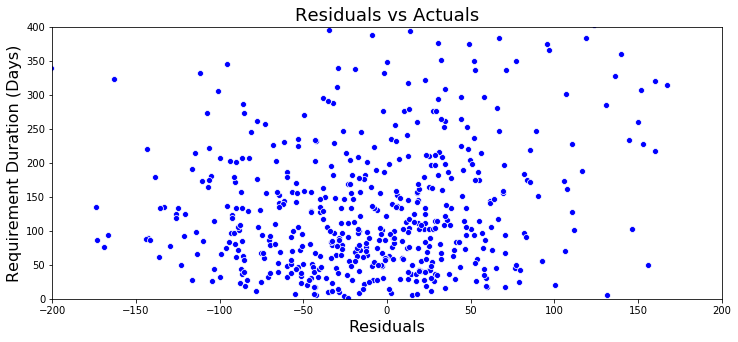

In [31]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=res.resid, y=all_data['duration_mean'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Requirement Duration (Days)', fontsize=16)
plt.ylim([0, 400])
plt.xlim([-200, 200])

In [32]:
all_data['duration_prediction'] = res.predict(X)

Text(0.5, 0, 'Average Clustering Coefficient')

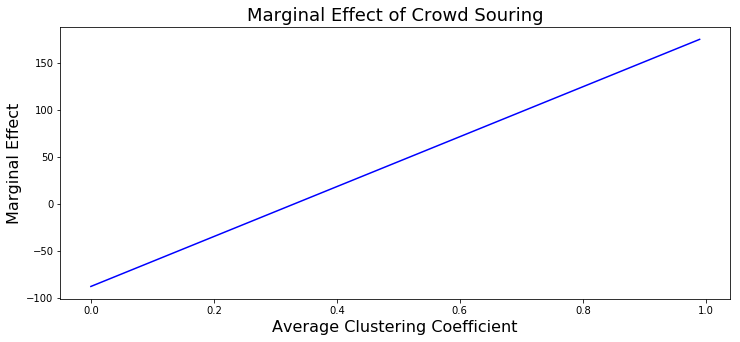

In [33]:
total_effect = lambda x: res.params['crowd_pct'] + x*res.params['avg_clusteringXcrowd_pct']
effects = pd.DataFrame({'avg_clustering': [i/100 for i in range(100)], 
                        'total_effect': [total_effect(i/100) for i in range(100)]})

plt.figure(figsize=(12, 5))
sns.lineplot(y=effects['total_effect'], x=effects['avg_clustering'], color='blue')
plt.title('Marginal Effect of Crowd Souring', fontsize=18)
plt.ylabel('Marginal Effect', fontsize=16)
plt.xlabel('Average Clustering Coefficient', fontsize=16)

### Regression on Issues Submitted Over Time

Text(0, 0.5, 'Count')

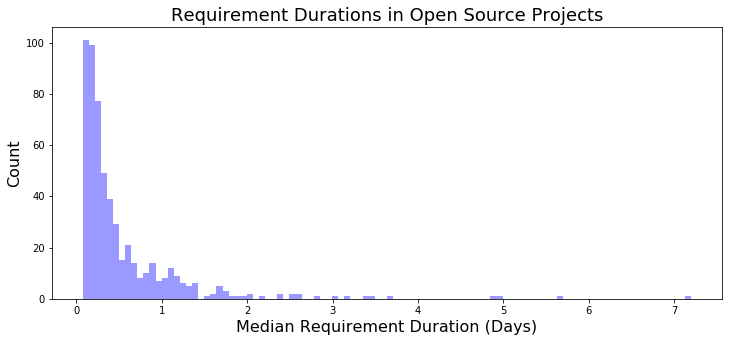

In [34]:
plt.figure(figsize=(12, 5))
sns.distplot(all_data['issues_over_time'], kde=False, color='blue', bins=100)
plt.title('Requirement Durations in Open Source Projects', fontsize=18)
plt.xlabel('Median Requirement Duration (Days)', fontsize=16)
plt.ylabel('Count', fontsize=16)

In [35]:
all_data['issues_over_time'].describe()

count    562.000000
mean       0.529492
std        0.692128
min        0.071283
25%        0.171376
50%        0.291423
75%        0.606494
max        7.200358
Name: issues_over_time, dtype: float64

In [36]:
y, X = dmatrices('issues_over_time ~ ' + base_features,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       issues_over_time   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     46.28
Date:                Mon, 09 Dec 2019   Prob (F-statistic):           1.22e-66
Time:                        23:34:31   Log-Likelihood:                -418.79
No. Observations:                 562   AIC:                             859.6
Df Residuals:                     551   BIC:                             907.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [37]:
y, X = dmatrices('issues_over_time ~ ' + base_features + ' + ' + ' + '.join(reg_topics),
                 data=all_data, return_type='dataframe')
features = utils.select_features(X, y, .05)
y, X = dmatrices('issues_over_time ~ ' + features,
                 data=all_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
yhat = res.predict(X)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       issues_over_time   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     23.50
Date:                Mon, 09 Dec 2019   Prob (F-statistic):          1.66e-117
Time:                        23:34:49   Log-Likelihood:                -177.04
No. Observations:                 562   AIC:                             496.1
Df Residuals:                     491   BIC:                             803.6
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [38]:
all_data['issue_fresuency_prediction'] = res.predict(X)

(-1.0, 1.0)

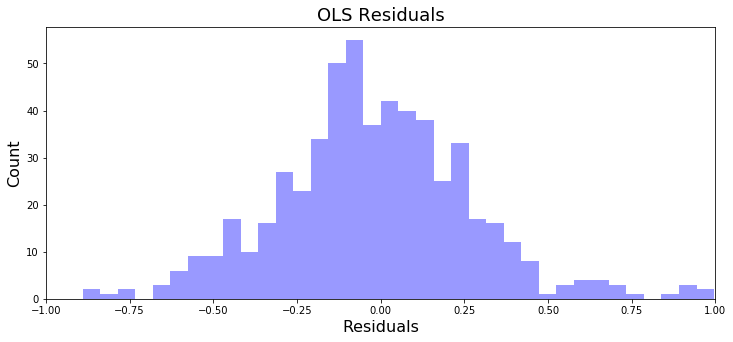

In [39]:
plt.figure(figsize=(12, 5))
sns.distplot(res.resid, kde=False, color='blue', bins=50)
plt.title('OLS Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xlim([-1.0, 1.0])

(-0.75, 0.75)

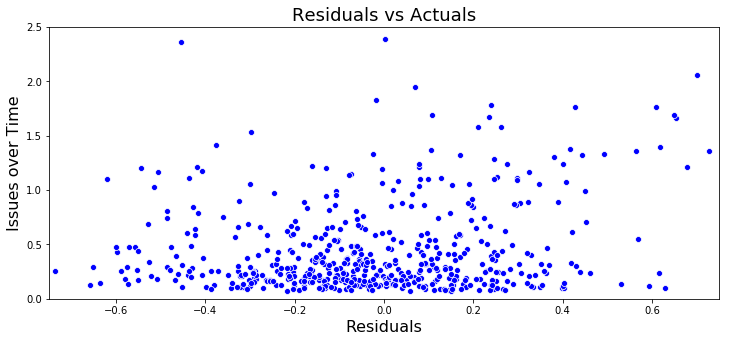

In [40]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=res.resid, y=all_data['issues_over_time'], color='blue')
plt.title('Residuals vs Actuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Issues over Time', fontsize=16)
plt.ylim([0, 2.5])
plt.xlim([-0.75, .75])

Text(0.5, 0, 'Crowd Source Percentage')

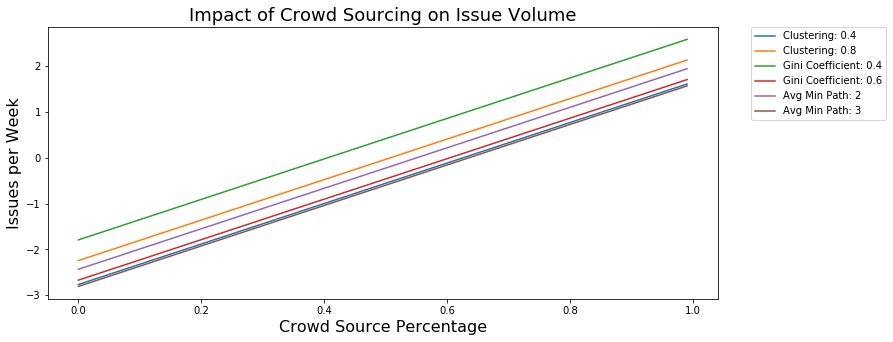

In [41]:
plt.figure(figsize=(12, 5))

for avg_clustering in [0.4, 0.8]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Clustering: {}'.format(avg_clustering)
    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['crowd_pct_2'] = crowd_pct**2
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct* avg_clustering
        effects_data['avg_min_pathXcrowd_pct'] = crowd_pct * all_data['avg_min_path']
        effects_data['gini_coefficientXcrowd_pct'] = crowd_pct * all_data['gini_coefficient']
        effects_data['crowd_pct_param'] = (avg_clustering * res.params['avg_clusteringXcrowd_pct']
                                           + all_data['avg_min_path'] * res.params['avg_min_pathXcrowd_pct']
                                           + all_data['gini_coefficient'] * res.params['gini_coefficientXcrowd_pct'])
        effects_data['total_effect'] = effects_data['crowd_pct_param'] + (2 * res.params['crowd_pct_2'] * crowd_pct)
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
    marginal_effects = pd.DataFrame(marginal_effects)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)
    
for gini_coefficient in [0.4, 0.6]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Gini Coefficient: {}'.format(gini_coefficient)
    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['crowd_pct_2'] = crowd_pct**2
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct* all_data['avg_clustering']
        effects_data['avg_min_pathXcrowd_pct'] = crowd_pct * all_data['avg_min_path']
        effects_data['gini_coefficientXcrowd_pct'] = crowd_pct * gini_coefficient
        effects_data['crowd_pct_param'] = (all_data['avg_clustering'] * res.params['avg_clusteringXcrowd_pct']
                                           + all_data['avg_min_path'] * res.params['avg_min_pathXcrowd_pct']
                                           + gini_coefficient * res.params['gini_coefficientXcrowd_pct'])
        effects_data['total_effect'] = effects_data['crowd_pct_param'] + (2 * res.params['crowd_pct_2'] * crowd_pct)
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
    marginal_effects = pd.DataFrame(marginal_effects)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)
    
for avg_min_path in [2, 3]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Min Path: {}'.format(avg_min_path)
    for i in range(100):
        effects_data = X.copy(deep=True)
        crowd_pct = i/100
        effects_data['crowd_pct_2'] = crowd_pct**2
        effects_data['avg_clusteringXcrowd_pct'] = crowd_pct* all_data['avg_clustering']
        effects_data['avg_min_pathXcrowd_pct'] = crowd_pct * avg_min_path
        effects_data['gini_coefficientXcrowd_pct'] = crowd_pct * all_data['gini_coefficient']
        effects_data['crowd_pct_param'] = (all_data['avg_clustering'] * res.params['avg_clusteringXcrowd_pct']
                                           + avg_min_path * res.params['avg_min_pathXcrowd_pct']
                                           + all_data['gini_coefficient'] * res.params['gini_coefficientXcrowd_pct'])
        effects_data['total_effect'] = effects_data['crowd_pct_param'] + (2 * res.params['crowd_pct_2'] * crowd_pct)
        avg_effect = effects_data['total_effect'].mean()
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
    marginal_effects = pd.DataFrame(marginal_effects)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Impact of Crowd Sourcing on Issue Volume', fontsize=18)
plt.ylabel('Issues per Week', fontsize=16)
plt.xlabel('Crowd Source Percentage', fontsize=16)

### Regression on Document Diversity

In [42]:
num_topics = []
for i in all_data.index:
    topics = 0
    for j in range(25):
        if df.loc[i]['topic_{}'.format(j)] > topics:
            topics = df.loc[i]['topic_{}'.format(j)]
    num_topics.append(topics)
all_data['num_topics'] = num_topics